## Step 1
### Target
1. Create a Setup (dataset, data loader, train/test steps and log plots)
2. Defining simple model with Convolution block, GAP.


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Dataloader Arguments & Test/Train Dataloaders

In [4]:

cuda = torch.cuda.is_available()
print("CUDA Availalbe: ", cuda)


# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe:  True


## Model

In [5]:
from model import Model_1
Net = Model_1

## Model Params

In [6]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

## Training and Testing

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.21125341951847076 Batch_id=468 Accuracy=91.14: 100%|██████████| 469/469 [00:30<00:00, 15.26it/s] 



Test set: Average loss: 0.0692, Accuracy: 9796/10000 (97.96%)

EPOCH: 1


Loss=0.12738344073295593 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:33<00:00, 13.81it/s] 



Test set: Average loss: 0.0542, Accuracy: 9828/10000 (98.28%)

EPOCH: 2


Loss=0.03428314998745918 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:31<00:00, 15.07it/s] 



Test set: Average loss: 0.0444, Accuracy: 9856/10000 (98.56%)

EPOCH: 3


Loss=0.051162347197532654 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s] 



Test set: Average loss: 0.0392, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.09397699683904648 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:30<00:00, 15.27it/s] 



Test set: Average loss: 0.0328, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.042218372225761414 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:29<00:00, 15.89it/s]



Test set: Average loss: 0.0329, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.03632233664393425 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:30<00:00, 15.59it/s]  



Test set: Average loss: 0.0328, Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.05642245337367058 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s] 



Test set: Average loss: 0.0316, Accuracy: 9890/10000 (98.90%)

EPOCH: 8


Loss=0.022944970056414604 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]



Test set: Average loss: 0.0287, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


Loss=0.10683336108922958 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]  



Test set: Average loss: 0.0264, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.029766136780381203 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:29<00:00, 15.63it/s] 



Test set: Average loss: 0.0251, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.13788092136383057 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:29<00:00, 15.80it/s]  



Test set: Average loss: 0.0263, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


Loss=0.09901636093854904 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:29<00:00, 15.71it/s]  



Test set: Average loss: 0.0289, Accuracy: 9885/10000 (98.85%)

EPOCH: 13


Loss=0.10207656770944595 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:29<00:00, 16.06it/s]  



Test set: Average loss: 0.0285, Accuracy: 9898/10000 (98.98%)

EPOCH: 14


Loss=0.031570691615343094 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:30<00:00, 15.63it/s] 



Test set: Average loss: 0.0282, Accuracy: 9901/10000 (99.01%)



Text(0.5, 1.0, 'Test Accuracy')

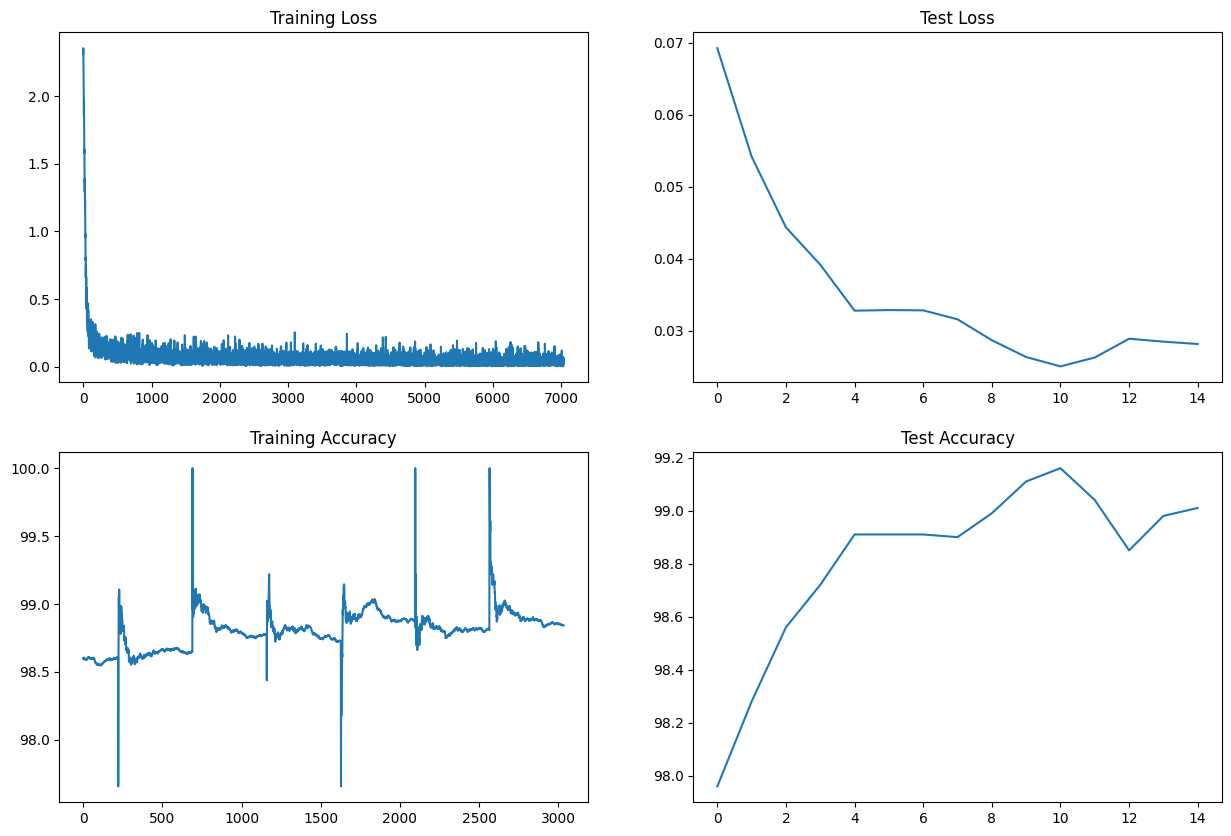

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")